In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image, ImageFile, UnidentifiedImageError
import os
import pycaret 
ImageFile.LOAD_TRUNCATED_IMAGES = True 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision 
from torchvision import datasets, models, transforms 
from tempfile import TemporaryDirectory 
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from torchvision.models import resnet18, resnet50, VGG19_Weights
import warnings
warnings.filterwarnings("ignore") 
# from sklearn.model_selection import train_test_split
# import mlflow                                   
# import mlflow.pytorch
# Ignorer tous les avertissements
# from torchmetrics.classification import Accuracy
# from efficientnet_pytorch import EfficientNet
# import pretrainedmodels
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### CONCATENATION DES FICHIERS 

In [2]:
n_files = 11 # Remplace ceci par le nombre exact de fichiers CSV que tu as

# Crée une liste des chemins des fichiers CSV
file_paths = [f'/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df{i}.csv' for i in range(n_files)]

# Lire les fichiers CSV et stocker les DataFrames dans une liste
list_df = [pd.read_csv(file_path) for file_path in file_paths] 
print(len(list_df))
df_final = pd.concat(list_df, ignore_index=True) 

11


In [3]:
df_final.shape

(1076, 4363)

### ANALYSE EN COMPOSANTE PRINCIPALE

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df_final.drop(columns=['cluster','Unnamed: 0'])  # Variables indépendantes
# Étape 1 : Normalisation des données
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)  # Normaliser tes données (X est ton jeu de données)

# Étape 2 : Application de l'ACP
pca = PCA(n_components = 0.8)  # Conserver 95% de la variance expliquée
X_pca = pca.fit_transform(X_scaled) 

# Afficher la variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale : ", sum(pca.explained_variance_ratio_))
print("Nombre de composantes principales sélectionnées : ", pca.n_components_)  

Variance expliquée par chaque composante principale :  0.8002580570676402
Nombre de composantes principales sélectionnées :  445


In [5]:
import pickle

# Enregistrer le modèle
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/ACP_SUP.pkl', 'wb') as acp:
    pickle.dump(pca, acp)  

with open('/opt/spark-apps/programs/Gohou/Data/Tabes/scaler_SUP.pkl', 'wb') as scale:
    pickle.dump(scaler, scale)  



In [12]:
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df = pd.concat([X_pca_df, df_final['cluster']], axis=1) 
df.shape

(493, 254)

In [13]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
df.shape

(493, 254)

### CHARGEMENT DES MODULES NECESSAIRE AU MACHINE LEARNING 

In [15]:
import time
import xgboost as xgb
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict, train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,ElasticNet, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

### REECHANTILLONNAGE DES DONNEES 

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X = df.drop(columns='cluster')  # Variables indépendantes
y = df['cluster'] 

# # Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)

# Application de SMOTE pour suréchantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier la distribution des classes après suréchantillonnage
print("Distribution des classes avant suréchantillonnage :", Counter(y_train))
print("Distribution des classes après suréchantillonnage :", Counter(y_train_resampled))

NameError: name 'df' is not defined

### CHOIX DES MEILLEURS HYPERPARAMETRES PAR MODELES 

In [34]:
a = int(np.sqrt(len(X_train_resampled.columns))) 
dico = {
    'logistic': LogisticRegression(),
    'elastic': LogisticRegression(penalty="elasticnet", solver="saga"),  #met beaucoup de temps 
    'ridge': LogisticRegression(penalty="l2"),
    'lasso': LogisticRegression(penalty="l1"),
    'Arbre': DecisionTreeClassifier(),
    'Random': RandomForestClassifier(),
    'xgb': xgb.XGBClassifier(),
    'knn': KNeighborsClassifier(),
    'Gradient_boosting': GradientBoostingClassifier(),
    'adaboost_classifier': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(DecisionTreeClassifier()),
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'lightgbm': LGBMClassifier(),  # Ajout de LightGBM
    'catboost': CatBoostClassifier(verbose=0)  # Ajout de CatBoost
}

# 0.001, 0.01, 0.1, 1, 10
param = [
    {"C": [0.001, 0.1, 1, 10], "max_iter": [10000]},
    {"C": [0.001, 0.1, 1, 10], "l1_ratio": [0.1, 0.5, 0.7], "max_iter": [10000]},
    {"C": [0.001, 0.1, 1, 10], "solver": ["sag", "lbfgs", "liblinear"], "max_iter": [10000]},
    {"C": [0.001, 0.1, 1, 10], "solver": ["liblinear"], "max_iter": [10000]},
    {"max_depth": [5, 10, 20], "min_samples_split": [10, 15], "min_samples_leaf": [5, 7]},
    {"n_estimators": [100, 200, 150], "min_samples_leaf": [3, 5, 7], "max_features": [0.7, 0.8], "max_depth": [3, 4, 5]},
    {'colsample_bytree': [0.5, 0.7], "n_estimators": [100, 200, 150], "max_depth": [4, 5, 7], "objective": ["multi:softmax"], "num_class": [4], "subsample": [0.7, 0.8]},
    {'n_neighbors': [3, 5, 7], "algorithm": ["auto", "ball_tree", "kd_tree"]},
    {"n_estimators": [100, 200, 150], "max_depth": [5, 6, 7], "learning_rate": [0.01, 0.1], "min_samples_split": [10, 15], "min_samples_leaf": [5, 7], "subsample": [0.7, 0.8]},
    {"n_estimators": [70, 100], "learning_rate": [0.01, 0.1], "algorithm": ["SAMME", "SAMME.R"]},
    {"n_estimators": [100, 80], "max_features": [0.7, 0.8], "max_samples":[0.7, 0.8]},
    {"kernel": ['linear', 'rbf'], "C": [0.01, 0.1, 1], "gamma": ["scale", "auto"]},
    {"solver": ["eigen", "lsqr"], "shrinkage": ["auto"]}, 
    {"reg_param": [0.0, 0.1, 0.2, 0.3], "tol": [1e-4, 1e-3, 1e-2]},
    {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [5, 10], "num_leaves": [20, 30, 40], "colsample_bytree": [0.5, 0.7], "force_row_wise": [True], 'verbose': [-1]},
    {"iterations": [100, 200], "depth": [6, 8, 10], "learning_rate": [0.01, 0.1], "l2_leaf_reg": [1, 3, 5]}
] 

In [35]:
def train_model(nom_model, dico, param, X_train_resampled, y_train_resampled, kf, out):
    model = dico[nom_model]
    model_cv = GridSearchCV(model, param_grid=param, cv=kf, scoring="f1_weighted", error_score="raise")  # Utiliser "f1" au lieu de "f1_score"
    temps_debut = time.time() 
    model_cv.fit(X_train_resampled, y_train_resampled) 
    temps_fin = time.time()
    # temps_execution = temps_fin - temps_debut
    out[nom_model]={"best_model":model_cv.best_estimator_,"meilleurs_parametres":model_cv.best_params_, "f1_score": model_cv.best_score_,"temps":[time.ctime(temps_debut), time.ctime(temps_fin)]}
    print(f'-----------------  Entrainement de {nom_model} est terminé  -----------------')

In [36]:
import threading
kf = KFold(n_splits=4, shuffle=True, random_state=42)
out = {}
threads = []

# Launch a thread for each model in the dictionary
for i, nom_model in enumerate(dico):
    param_v = param[i]
    thread = threading.Thread(target=train_model, args=(nom_model, dico, param_v, X_train_resampled, y_train_resampled, kf, out))
    threads.append(thread)
    thread.start() 

-----------------  Entrainement de lasso est terminé  -----------------
-----------------  Entrainement de LDA est terminé  -----------------
-----------------  Entrainement de SVM est terminé  -----------------
-----------------  Entrainement de knn est terminé  -----------------
-----------------  Entrainement de Arbre est terminé  -----------------
-----------------  Entrainement de elastic est terminé  -----------------


In [5]:
out_1  = pd.DataFrame.from_dict(out, orient='index')
out_1

NameError: name 'out' is not defined

In [62]:
out_1.loc["Random","meilleurs_parametres"] 

{'max_depth': 5,
 'max_features': 0.7,
 'min_samples_leaf': 3,
 'n_estimators': 200}

In [19]:
# X_train_resampled.columns[0:3] 

In [20]:
# print(out_1.loc["lasso","best_model"].coef_.shape)

In [ ]:
# Pour s'assurer que tous les threads individuelles soient terminés avant que le thread principal prenne le relai. 
# On en pas besoin si on sait à quel moment tous nos threads vont tous se stopper 

for thread in threads:
    thread.join() 
print(out) 

### CHOIX DU MEILLEUR MODELE 

In [14]:
def train_best(out, result, position): 
    kf = KFold(n_splits=10, shuffle=True, random_state=42) 
    model = list(out.values())[position]["best_model"] 
    nom = list(out.keys())[position]  
    predictions = cross_val_predict(model, X_train_resampled, y_train_resampled, cv = kf)
    result[nom] = {"Modele":model, "F1_Score": f1_score(y_train_resampled, predictions, average='weighted')} 
    print(f'----------------- Entrainement de {nom} est terminé --------------------') 

#### **On fait Ici des entrainement des modèles de façon paralleles en utilisant des threads**

In [15]:
result = {}
threads_best = [] 

# Launch a thread for each model in the dictionary
for i, nom_model in enumerate(out):
    position = i
    thread1 = threading.Thread(target=train_best, args=(out, result, position))
    threads_best.append(thread1)
    thread1.start()   

----------------- Entrainement de knn est terminé --------------------
----------------- Entrainement de Arbre est terminé --------------------
----------------- Entrainement de lasso est terminé --------------------
----------------- Entrainement de LDA est terminé --------------------


In [169]:
df_result = pd.DataFrame.from_dict(result, orient='index') 
df_result 

,Modele,F1_Score
knn,KNeighborsClassifier(n_neighbors=3),0.636423
Arbre,"DecisionTreeClassifier(max_depth=20, min_sampl...",0.571530
lasso,"LogisticRegression(C=1, max_iter=9000, penalty...",0.712651
LDA,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.679374
Bagging,(DecisionTreeClassifier(random_state=136928537...,0.869069
Random,"(DecisionTreeClassifier(max_features=28, min_s...",0.882121
catboost,<catboost.core.CatBoostClassifier object at 0x...,0.827834
xgb,"XGBClassifier(base_score=None, booster=None, c...",0.867115
lightgbm,"LGBMClassifier(force_row_wise=True, learning_r...",0.873806
adaboost_classifier,"(DecisionTreeClassifier(max_depth=1, random_st...",0.543241


In [44]:
df_result_new = pd.DataFrame.from_dict(result, orient='index') 
df_result_new 

,Modele,F1_Score
knn,KNeighborsClassifier(n_neighbors=3),0.624529
Arbre,"DecisionTreeClassifier(max_depth=20, min_sampl...",0.555693
lasso,"LogisticRegression(C=1, max_iter=10000, penalt...",0.739199
LDA,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.701014


In [132]:
import pickle

# Enregistrer le modèle
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/Random.pkl', 'wb') as file:
    pickle.dump(result['catboost']["Modele"], file)  

In [177]:
# result['catboost']["Modele"].save_model('/opt/spark-apps/programs/Gohou/Data/Tabes/catboost.cbm')
cat = CatBoostClassifier()
cat.load_model('/opt/spark-apps/programs/Gohou/Data/Tabes/catboost.cbm') 

In [28]:
out_1.loc["LDA","meilleurs_parametres"] 

{'shrinkage': 'auto', 'solver': 'eigen'}

In [50]:
pred = out_1.loc["Bagging","best_model"].predict(X_test)
f1_test = f1_score(y_test, pred, average='weighted')
# X_train_resampled, y_train_resampled
# f1_test = f1_score(y_train_resampled, pred, average='weighted')
# f1_test = accuracy_score(y_test, pred)
print(f1_test)  

0.38988589815202723


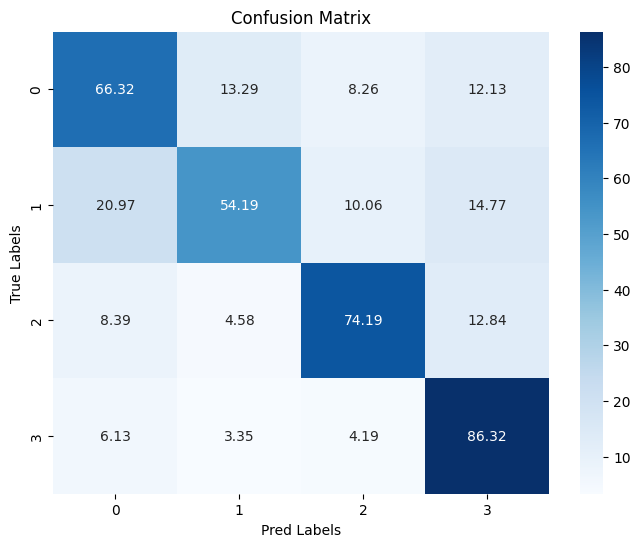

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
cm = confusion_matrix(y_train_resampled, pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
# sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False) 
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Pred Labels')
plt.ylabel('True Labels')
plt.show()

In [124]:
# Charger le modèle plus tard
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/Random.pkl', 'rb') as file:
    loaded_model = pickle.load(file) 

In [120]:
a = X_test.reset_index(drop=True)
x = a.loc[0,:]

PC1    -3.870732
PC2     8.968597
PC3    -8.871503
PC4    -9.112597
PC5   -10.086656
Name: 0, dtype: float64

In [164]:
# X_test.head()

In [130]:
pr = loaded_model.predict(a.loc[7,:].values.reshape(1, -1))
print(pr)

[2]


In [ ]:
# Join all threads (wait for them to finish)
for thread1 in threads_best:
    thread1.join()
print(result) 

### AFFICHER LE MEILLEUR DES MEILLEURS PUIS ENTRAINEMENT SUR TOUTE LA DONNEES

In [89]:
meilleur_modele = df_result.loc[df_result["F1_Score"].idxmax()] 
meilleur_modele

Modele      LogisticRegression(C=1, max_iter=9000, penalty...
F1_Score                                             0.712651
Name: lasso, dtype: object

### Tester Le meilleur modele 

### Courbe d'apprentissage 

In [106]:
# param1 = {"n_estimators": [100, 80], "max_features": [0.7, 0.8], "max_samples":[0.7, 0.8]}
# kf1 = KFold(n_splits= 4, shuffle=True, random_state=42) 
# mo = GridSearchCV( BaggingClassifier(DecisionTreeClassifier()), param_grid=param1, cv=kf1, scoring="f1_weighted", error_score="raise")
# mo.fit(X_train_resampled, y_train_resampled)

# predictions = cross_val_predict(mo, X_train_resampled, y_train_resampled, cv = kf1) 
# f1_train = f1_score(y_train_resampled, predictions, average='weighted')
# print(f"F1 Score d'entraînement : {f1_train}")

# pred_test = mo.best_estimator_.predict(X_test)
# f1_test = f1_score(y_test, pred_test, average='weighted')
# print(f"F1 Score de test : {f1_test}")

# print(f"Meilleurs paramètres : {mo.best_params_}") 